## Implémentation de la fonction ReQU (avec boucle)

In [73]:
-- Attention, penser que le module Requ n' pas de paramètre == pas de paramètre à calculer loss
local Requ, parent = torch.class('nn.Requ', 'nn.Module') -- heritage en torch
function Requ:__init() -- constructeur
    parent.__init(self)
    self.output=torch.Tensor()
    self.gradInput=torch.Tensor()
end

function Requ:updateOutput(input)
   -- self.output=torch.Tensor(input:size()[1])
    for i=1, input:size()[1] do
        if(input[i] >0) then
            self.output[i]=torch.pow(input,2)
        else
            self.output[i]=0
        end
    end
    return self.output
end

function Requ:updateGradInput(input,gradOutput)
   -- self.gradInput=torch.Tensor(input:size()[1])
    for i=1, input:size() do
        if(input[i]>0) then
            self.gradInput[i]=2*gradOutput[i]*input[i]
        else
            self.gradInput[i]=0
        end
    end
    return self.gradInput
end



## Implémentation de la fonction ReQU (sans boucle)

In [72]:
-- Attention, penser que le module Requ n' pas de paramètre == pas de paramètre à calculer loss
local Requ2, parent = torch.class('nn.Requ2', 'nn.Module') -- heritage en torch
function Requ2:__init() -- constructeur
    parent.__init(self)
    self.output=torch.Tensor()
    self.gradInput=torch.Tensor()
end

function Requ2:updateOutput(input)
    self.output=torch.pow(input,2)
    self.output=torch.gt(self.output,0)*self.output
    return self.output
end

function Requ2:updateGradInput(input,gradOutput)
    self.gradInput=torch.cmul(2*input,gradOutput)
    return self.gradInput
end



## Implémentation du Module LinearNoBias

In [45]:
require 'nn'
local LinearNoBias_test, parent = torch.class('LinearNoBias_test', 'nn.Module')

function LinearNoBias_test:__init(inputSize, outputSize)
    parent.__init(self)
    self.weight = torch.Tensor(outputSize, inputSize)
    self.gradWeight = torch.Tensor(outputSize, inputSize)
    self:reset()
    self.output:zero()
end


function LinearNoBias_test:updateOutput(input)
    if input:dim() == 1 then
        self.output:resize(self.weight:size(1))
        self.output:mv(self.weight, input)
    elseif input:dim() == 2 then
        self.output:resize(input:size(1), self.weight:size(1))
        self.output:addmm(0, self.output, 1, input, self.weight:t())
    end
    return self.output
end

function LinearNoBias_test:updateGradInput(input, gradOutput)
    self.gradInput = self.gradInput or input.new()
    self.gradInput:resizeAs(input)
    if input:dim() == 1 then
       self.gradInput:addmv(0, 1, self.weight:t(), gradOutput)
    elseif input:dim() == 2 then
       self.gradInput:addmm(0, 1, gradOutput, self.weight)
    end

    return self.gradInput
end

function LinearNoBias_test:accGradParameters(input, gradOutput, scale)
    scale = scale or 1
    if input:dim() == 1 then
        self.gradWeight:addr(scale, gradOutput, input)
    elseif input:dim() == 2 then
        self.gradWeight:addmm(scale, gradOutput:t(), input)
    end
end

function LinearNoBias_test:reset(stdv)
    stdv = stdv or 0.1
    self.weight:uniform(-stdv, stdv)
    return self
end


#### Archive code : https://web.archive.org/web/20150905061421/http://code.madbits.com/wiki/doku.php?id=tutorial_morestuff

In [54]:
function plot_points(xs,ys)  
  local nb_positive=ys:eq(1):sum()
  local nb_negative=ys:eq(-1):sum()
  local xs_positive=torch.Tensor(nb_positive,2)
  local xs_negative=torch.Tensor(nb_negative,2)
  local pos_positive=1
  local pos_negative=1
  for i=1,xs:size(1) do
    if (ys[i][1]==1) then xs_positive[pos_positive]:copy(xs[i]); pos_positive=pos_positive+1 
                   else xs_negative[pos_negative]:copy(xs[i]); pos_negative=pos_negative+1 end
  end
  
  return {{xs_positive:t()[1],xs_positive:t()[2],"with points"},{xs_negative:t()[1],xs_negative:t()[2],"with points"}}
end

function plot_model(model,x_min,x_max,y_min,y_max,step)
  local all_points={}
  local pos=1
    
  local p=torch.Tensor(2)
  for x=x_min,x_max,step do
    p[1]=x; p[2]=y_min; local v=model:forward(p)[1]
    if (v<0) then v=-1 else v=1 end
    for y=y_min+step,y_max,step do
      p[2]=y
      local val=model:forward(p)[1]
      if (val*v<=0) then 
        v=-v
        all_points[pos]={x,y}
        pos=pos+1
      end
    end
  end
  
  for y=y_min,y_max,step do
    p[1]=x_min; p[2]=y; local v=model:forward(p)[1]
    if (v<0) then v=-1 else v=1 end
    for x=x_min+step,x_max,step do
      p[1]=x
      local val=model:forward(p)[1]
      if (val*v<0) then 
        v=-v
        all_points[pos]={x,y}
        pos=pos+1
      end
    end
  end  
  
  local t=torch.Tensor(all_points)
  if (t:size(1)>0) then return {t:t()[1],t:t()[2],"with points"} end
end
 
function plot(xs,ys,model,precision)
  assert(xs:size(2)==2,"Dimension must be 2 for plotting")
  if (precision==nil) then precision=100 end
  local p1=plot_points(xs,ys,nil)
  local p2=plot_model(model,xs:t()[1]:min(),xs:t()[1]:max(),xs:t()[2]:min(),xs:t()[2]:max(),(xs:t()[1]:max()-xs:t()[1]:min())/precision)
  gnuplot.plot(p2,unpack(p1))
end
  


In [71]:
require 'nn'
require 'gnuplot'
require 'image'
require 'rnn'


---------------------------------------------
 --------------CREATE DATA ------------------
 --------------------------------------------

 local DIMENSION=2 -- dimension d'entrée
 local n_points=1000 -- nombre de points d'apprentissage  
 local mean_positive=torch.Tensor(DIMENSION):fill(2); 
 local var_positive=0.5
 local mean_negative=torch.Tensor(DIMENSION):fill(-2);
 local var_negative=0.5
 local xs=torch.Tensor(n_points,DIMENSION)
 local ys=torch.Tensor(n_points,1)
 for i=1,n_points/2 do
    xs[i]:copy(torch.randn(DIMENSION)*var_positive+mean_positive); 
    ys[i][1]=1 
 end
 for i=n_points/2+1,n_points do 
    xs[i]:copy(torch.randn(DIMENSION)*var_negative+mean_negative); 
    ys[i][1]=-1 
 end


---------------------------------------------
 --------------TRAINNING --------------------
 --------------------------------------------

local nbIter = 1000
local lr = 1e-4
criterion = nn.MSECriterion()
all_losses={}
model = LinearNoBias_test(2,1)
model_2=nn.LinearNoBias(2,1)
for iteration = 1, nbIter do
    for i=1, xs:size(1) do
      model_2.weight = model.weight:clone()
      model:zeroGradParameters()
      model_2:zeroGradParameters()
      -- Forward Pass
      output = model:forward(xs[i])
      output_2=model_2:forward(xs[i])
      -- Compute Diference between output model & model_2
      if(torch.sum(output-output_2) ~= 0) then
          print("forward error = "..torch.sum(output-output_2))
      end
      loss = criterion:forward(output, ys[i])
      loss_2 = criterion:forward(output_2, ys[i])
    
      -- Backward Pass
      delta = criterion:backward(output, ys[i])
      delta_2 = criterion:backward(output_2, ys[i])
      back=model:backward(xs[i], delta)
      back_2=model_2:backward(xs[i], delta_2)
      -- Compute Diference between backward model & model_2
      if(torch.sum(back-back_2) ~= 0) then
          print("forward error = "..torch.sum(back-back_2))
      end
      model:updateParameters(lr)
      model_2:updateParameters(lr)
    end
      table.insert(all_losses,loss)  
end
--plot(xs,ys,model_2,100)
--plot(xs,ys,model,100,'testdiff/fals_nobias.eps')
   -- gnuplot.plot(torch.Tensor(all_losses))


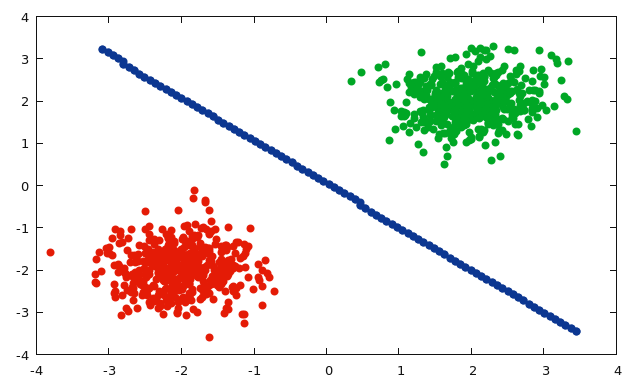

In [70]:
itorch.image('test_nobias')


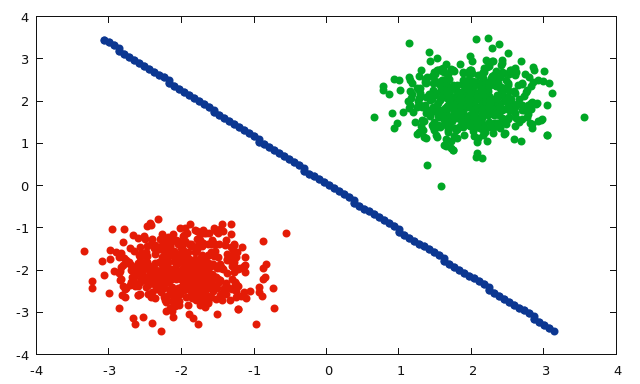

In [69]:
itorch.image('test_bias')

Les deux images sont identiques, nous avons donc bien implémenté le module LinearNoBias_test